This code uses the skipgram model to create word2vec encodings and then use those encodings to represent the input words to our model.

In [1]:
import numpy as np
import pandas as pd

from tensorflow import one_hot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence

import re
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import gensim

In [42]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

#Number of times to duplicate identity_hate
repeats=1 

In [43]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\n]')
BAD_SYMBOLS_RE = re.compile('[^a-z ]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [44]:
train=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/train.csv.zip")
train['comment_text'] = train['comment_text'].apply(clean_text)

In [45]:
oversamp=train[train['identity_hate']==1]
oversamp.head()
train=train.append(oversamp*repeats,ignore_index=True)
del oversamp

In [46]:
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train["comment_text"].values)

In [47]:
X = tokenizer.texts_to_sequences(train["comment_text"].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [48]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].to_numpy()

In [49]:
del train

In [58]:
google_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [92]:
dic=tokenizer.word_index
weights=[np.zeros((300,)).tolist()]
for i,word in enumerate(dic.keys()):
    if i>(MAX_NB_WORDS-2):
        break
    try:
        wei=google_model[word].tolist()
        if len(wei)!=300:
            print(word)
        weights.append(wei)
    except KeyError:
        weights.append(np.random.rand(300,).tolist())

In [93]:
weights=np.array(weights)

In [94]:
weights=[weights]

In [98]:
del google_model

In [95]:
rnn_model = keras.Sequential()
rnn_model.add(layers.Embedding(MAX_NB_WORDS, 300, input_length=1)) #has to be 300 cuz of google model
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(layers.Dense(6, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.AUC(multi_label=True)])

In [96]:
rnn_model.layers[0].get_weights()[0].shape

(50000, 300)

In [97]:
rnn_model.layers[0].set_weights(weights)

In [99]:
rnn_model.layers[0].trainable = False

In [100]:
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1, 300)            15000000  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 300)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total params: 15,070,506
Trainable params: 70,506
Non-trainable params: 15,000,000
_________________________________________________________________


In [101]:
epochs = 2
batch_size = 512

In [103]:
history = rnn_model.fit(X, y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
283/283 [==============================] - 227s 791ms/step - loss: 0.2192 - binary_accuracy: 0.9338 - auc_3: 0.6929 - val_loss: 0.1234 - val_binary_accuracy: 0.9554 - val_auc_3: 0.9616
Epoch 2/3
283/283 [==============================] - 223s 786ms/step - loss: 0.0527 - binary_accuracy: 0.9817 - auc_3: 0.9621 - val_loss: 0.1118 - val_binary_accuracy: 0.9577 - val_auc_3: 0.9617
Epoch 3/3
283/283 [==============================] - 230s 812ms/step - loss: 0.0455 - binary_accuracy: 0.9834 - auc_3: 0.9668 - val_loss: 0.1070 - val_binary_accuracy: 0.9588 - val_auc_3: 0.9624


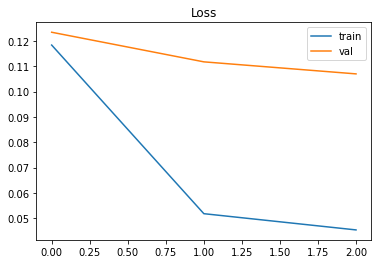

In [104]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

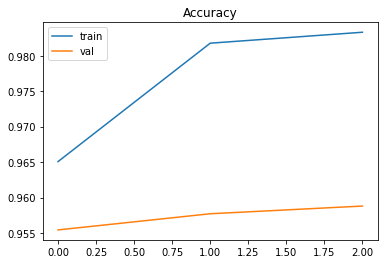

In [105]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.legend()
plt.show();

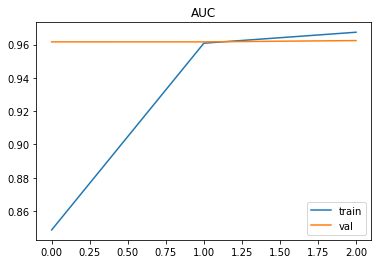

In [109]:
plt.title('AUC')
plt.plot(history.history['auc_3'], label='train')
plt.plot(history.history['val_auc_3'], label='val')
plt.legend()
plt.show();

In [110]:
rnn_model.layers[0].trainable = True

In [119]:
Second_epochs=4
history = rnn_model.fit(X, y, epochs=Second_epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
283/283 [==============================] - 225s 794ms/step - loss: 0.0346 - binary_accuracy: 0.9868 - auc_3: 0.9845 - val_loss: 0.0845 - val_binary_accuracy: 0.9663 - val_auc_3: 0.9777
Epoch 2/2
283/283 [==============================] - 230s 814ms/step - loss: 0.0317 - binary_accuracy: 0.9879 - auc_3: 0.9869 - val_loss: 0.0830 - val_binary_accuracy: 0.9686 - val_auc_3: 0.9762


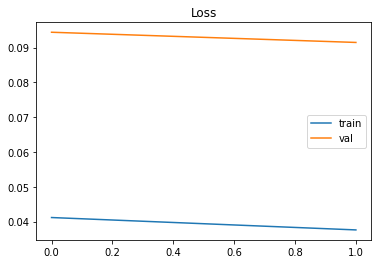

In [112]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

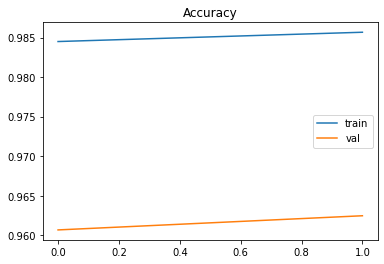

In [113]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.legend()
plt.show();

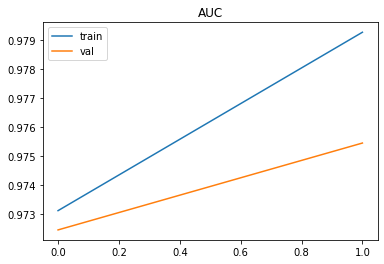

In [114]:
plt.title('AUC')
plt.plot(history.history['auc_3'], label='train')
plt.plot(history.history['val_auc_3'], label='val')
plt.legend()
plt.show();

In [ ]:
del X
del y

In [115]:
test=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_lab = pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [116]:
df_test = test.merge(test_lab, on = 'id')
df_test = df_test[df_test['toxic'] != -1]
y_test = df_test[list_classes].to_numpy()

In [117]:
df_test['comment_text'] = df_test['comment_text'].apply(clean_text)
X_test = tokenizer.texts_to_sequences(df_test["comment_text"].values)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [142]:
y_test.shape

(63978, 6)

In [120]:
rnn_model.evaluate(X_test,y_test)

2000/2000 [==============================] - 23s 11ms/step - loss: 0.0750 - binary_accuracy: 0.9695 - auc_3: 0.9650


[0.07499382644891739, 0.9694973826408386, 0.9650154709815979]

In [142]:
new_insult = ['he said he saw him die']
new_insult[0] = clean_text(new_insult[0])
seq = tokenizer.texts_to_sequences(new_insult)
padded = sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = rnn_model.predict(padded)

In [143]:
pred

array([[0.45215753, 0.01638681, 0.0511145 , 0.16597581, 0.0685457 ,
        0.01877069]], dtype=float32)